# 🚀 한국어-영어 번역 Transformer (최종 개선 버전)

## 주요 개선 사항
| 항목 | 기존 | 개선 |
|------|------|------|
| **Embedding Scaling** | ❌ 없음 | ✅ `* sqrt(d_model)` |
| **Weight Tying** | ❌ 없음 | ✅ dec_embed = output_proj |
| **활성화 함수** | ReLU | **GELU** |
| **d_model** | 256 | **512** |
| **ffn_dim** | 1024 | **2048** |
| **Learning Rate** | 고정 0.0005 | **Warmup Scheduler** |

---

# 1. 환경 설정

In [1]:
!pip install -q sentencepiece easydict koeda

import os, re, math, time, random
from typing import List, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import sentencepiece as spm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from easydict import EasyDict
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 42.1 MB/s eta 0:00:00
Device: cuda


# 2. 경로 설정

In [2]:
DATA_DIR = '/content/work/dataset'
MODEL_DIR = '/content/work/models'
TOKENIZER_DIR = '/content/work/tokenizers'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

MODEL_SAVE_PATH = f'{MODEL_DIR}/transformer_final.pt'
KOR_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/eng_kor'
ENG_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/kor_eng'

# 3. ⭐ 개선된 설정

In [3]:
DATA_CONFIG = EasyDict({
    'train_ratio': 0.8, 'val_ratio': 0.1, 'test_ratio': 0.1,
    'max_length': 60, 'vocab_size_eng': 8000, 'vocab_size_kor': 8000,
    'batch_size': 64,
})

MODEL_CONFIG = EasyDict({
    'emb_dim': 512,            # ⭐ 256 → 512
    'ffn_dim': 2048,           # ⭐ 1024 → 2048
    'num_heads': 8,
    'encoder_layers': 6, 'decoder_layers': 6,
    'dropout': 0.1, 'attention_dropout': 0.1,
    'max_position_embeddings': 128,
})

TRAIN_CONFIG = EasyDict({
    'num_epochs': 50,
    'warmup_steps': 4000,      # ⭐ Warmup!
    'betas': (0.9, 0.98), 'eps': 1e-9,
    'weight_decay': 0.0001, 'clip': 1.0,
    'label_smoothing': 0.1, 'patience': 7, 'min_delta': 1e-4,
})

print(f"d_model={MODEL_CONFIG.emb_dim}, ffn_dim={MODEL_CONFIG.ffn_dim}")
print(f"Warmup steps={TRAIN_CONFIG.warmup_steps}")

d_model=512, ffn_dim=2048
Warmup steps=4000


# 4. 데이터 다운로드 및 전처리

In [4]:
# 데이터 다운로드
!wget -q https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz -P {DATA_DIR}
!gzip -df {DATA_DIR}/korean-english-park.train.tar.gz 2>/dev/null || true
!tar -xf {DATA_DIR}/korean-english-park.train.tar -C {DATA_DIR} 2>/dev/null || true

with open(f'{DATA_DIR}/korean-english-park.train.ko', 'r', encoding='utf-8') as f:
    kor_sentences = [l.strip() for l in f]
with open(f'{DATA_DIR}/korean-english-park.train.en', 'r', encoding='utf-8') as f:
    eng_sentences = [l.strip() for l in f]

print(f"원본 데이터: {len(kor_sentences):,}개")

원본 데이터: 94,123개


In [5]:
# 전처리
def preprocess(sent, lang='kor'):
    sent = sent.strip()
    if lang == 'eng': sent = sent.lower()
    return re.sub(r'\s+', ' ', sent).strip()

eng_proc = [preprocess(s, 'eng') for s in tqdm(eng_sentences, desc='영어')]
kor_proc = [preprocess(s, 'kor') for s in tqdm(kor_sentences, desc='한국어')]

# 필터링
filtered = []
seen = set()
for e, k in zip(eng_proc, kor_proc):
    e_w, k_w = len(e.split()), len(k.split())
    if not (3 <= e_w <= 50 and 2 <= k_w <= 60): continue
    if (k, e) in seen: continue
    seen.add((k, e))
    if not re.search(r'[가-힣]', k) or not re.search(r'[a-z]', e): continue
    if len(k) < 5 or len(e) < 10: continue
    ratio = e_w / k_w if k_w > 0 else 0
    if not (0.5 <= ratio <= 3.0): continue
    filtered.append((e, k))

eng_filtered, kor_filtered = zip(*filtered)
print(f"전처리 후: {len(eng_filtered):,}개")

한국어: 100%|██████████| 94123/94123 [00:00<00:00, 156883.85it/s]


전처리 후: 75,254개


In [6]:
# 데이터 분할 및 30% 증강
train_ko, temp_ko, train_en, temp_en = train_test_split(kor_filtered, eng_filtered, test_size=0.2, random_state=SEED)
val_ko, test_ko, val_en, test_en = train_test_split(temp_ko, temp_en, test_size=0.5, random_state=SEED)

train_ko, train_en = list(train_ko), list(train_en)
val_ko, val_en = list(val_ko), list(val_en)
test_ko, test_en = list(test_ko), list(test_en)

try:
    from koeda import EDA
    eda = EDA(morpheme_analyzer='Okt', alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, prob_rd=0.1)

    aug_count = int(len(train_ko) * 0.3)
    aug_idx = random.sample(range(len(train_ko)), min(aug_count, len(train_ko)))
    aug_ko, aug_en = [], []

    for i in tqdm(aug_idx, desc='증강'):
        try:
            result = eda(train_ko[i])
            if isinstance(result, str) and result != train_ko[i]:
                aug_ko.append(result)
                aug_en.append(train_en[i])
        except: pass

    train_ko += aug_ko
    train_en += aug_en
    combined = list(zip(train_ko, train_en))
    random.shuffle(combined)
    train_ko, train_en = zip(*combined)
    train_ko, train_en = list(train_ko), list(train_en)
    print(f"증강 후 Train: {len(train_ko):,}개")
except Exception as e:
    print(f"증강 스킵: {e}")

print(f"Train: {len(train_ko):,}, Val: {len(val_ko):,}, Test: {len(test_ko):,}")

증강: 100%|██████████| 18060/18060 [01:26<00:00, 208.19it/s]


증강 후 Train: 77,512개
Train: 77,512, Val: 7,525, Test: 7,526


# 5. 토크나이저

In [7]:
def train_spm(data, prefix, vocab_size=8000):
    corpus = f'{prefix}_corpus.txt'
    with open(corpus, 'w', encoding='utf-8') as f:
        for line in data: f.write(line + '\n')
    spm.SentencePieceTrainer.Train(
        f'--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size} '
        f'--model_type=unigram --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --character_coverage=1.0'
    )
    os.remove(corpus)

class SPVocab:
    def __init__(self, path):
        self.sp = spm.SentencePieceProcessor(); self.sp.Load(path)
        self.PAD_ID, self.UNK_ID, self.BOS_ID, self.EOS_ID = 0, 1, 2, 3
        self.itos = [self.sp.IdToPiece(i) for i in range(self.sp.GetPieceSize())]
    def encode(self, t): return self.sp.EncodeAsIds(t)
    def decode(self, ids): return self.sp.DecodeIds([i for i in ids if i not in [0,2,3]])
    def __len__(self): return self.sp.GetPieceSize()

kor_path, eng_path = f'{KOR_TOKENIZER_PREFIX}.model', f'{ENG_TOKENIZER_PREFIX}.model'
if not (os.path.exists(kor_path) and os.path.exists(eng_path)):
    train_spm(train_ko + val_ko + test_ko, KOR_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_kor)
    train_spm(train_en + val_en + test_en, ENG_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_eng)

vocab_src = SPVocab(kor_path)
vocab_trg = SPVocab(eng_path)
print(f"Vocab: 한국어={len(vocab_src):,}, 영어={len(vocab_trg):,}")

Vocab: 한국어=8,000, 영어=8,000


# 6. Dataset & DataLoader

In [8]:
class TransDS(Dataset):
    def __init__(self, src, trg, v_src, v_trg, max_len=60):
        self.src, self.trg = src, trg
        self.v_src, self.v_trg, self.max_len = v_src, v_trg, max_len
    def __len__(self): return len(self.src)
    def __getitem__(self, i):
        s = [self.v_src.BOS_ID] + self.v_src.encode(self.src[i]) + [self.v_src.EOS_ID]
        t = [self.v_trg.BOS_ID] + self.v_trg.encode(self.trg[i]) + [self.v_trg.EOS_ID]
        return {'SRC': torch.tensor(s[:self.max_len]), 'TRG': torch.tensor(t[:self.max_len]),
                'SRC_TEXT': self.src[i], 'TRG_TEXT': self.trg[i]}

def collate(batch, pad=0):
    return {'SRC': pad_sequence([b['SRC'] for b in batch], True, pad),
            'TRG': pad_sequence([b['TRG'] for b in batch], True, pad),
            'SRC_TEXT': [b['SRC_TEXT'] for b in batch], 'TRG_TEXT': [b['TRG_TEXT'] for b in batch]}

train_ds = TransDS(train_ko, train_en, vocab_src, vocab_trg, DATA_CONFIG.max_length)
val_ds = TransDS(val_ko, val_en, vocab_src, vocab_trg, DATA_CONFIG.max_length)
test_ds = TransDS(test_ko, test_en, vocab_src, vocab_trg, DATA_CONFIG.max_length)

col_fn = lambda b: collate(b, vocab_src.PAD_ID)
train_loader = DataLoader(train_ds, DATA_CONFIG.batch_size, True, collate_fn=col_fn)
val_loader = DataLoader(val_ds, DATA_CONFIG.batch_size, False, collate_fn=col_fn)
test_loader = DataLoader(test_ds, DATA_CONFIG.batch_size, False, collate_fn=col_fn)
print(f"Batches: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

Batches: Train=1212, Val=118, Test=118


# 7. ⭐ Transformer 모델 (개선된 버전)

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads, dropout=0.0, bias=False, enc_dec=False, causal=False):
        super().__init__()
        self.emb_dim, self.num_heads = emb_dim, num_heads
        self.head_dim, self.dropout = emb_dim // num_heads, dropout
        self.enc_dec, self.causal = enc_dec, causal
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)

    def forward(self, q, k, mask=None):
        B, L, _ = q.shape
        Q = self.q_proj(q).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        key = k if self.enc_dec else q
        K = self.k_proj(key).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(key).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            if self.causal: scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(1), float('-inf'))
            else: scores = scores.masked_fill(mask.unsqueeze(1).unsqueeze(2), float('-inf'))

        attn = F.dropout(F.softmax(scores, -1), self.dropout, self.training)
        out = torch.matmul(attn, V).transpose(1, 2).contiguous().view(B, L, self.emb_dim)
        return self.out_proj(out), attn


class FFN(nn.Module):
    def __init__(self, emb_dim, ff_dim, dropout=0.1):
        super().__init__()
        self.w1, self.w2 = nn.Linear(emb_dim, ff_dim), nn.Linear(ff_dim, emb_dim)
        self.dropout = dropout
        self.act = nn.GELU()  # ⭐ GELU (ReLU 대신)

    def forward(self, x):
        return F.dropout(self.w2(F.dropout(self.act(self.w1(x)), self.dropout, self.training)), self.dropout, self.training)


class SinPosEmb(nn.Embedding):
    def __init__(self, n_pos, dim, pad_idx=None):
        super().__init__(n_pos, dim)
        pe = torch.zeros(n_pos, dim)
        for pos in range(n_pos):
            for i in range(0, dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (i / dim)))
                if i + 1 < dim: pe[pos, i+1] = math.cos(pos / (10000 ** ((i+1) / dim)))
        self.weight.data.copy_(pe); self.weight.requires_grad = False

    @torch.no_grad()
    def forward(self, x): return super().forward(torch.arange(x.size(1), device=self.weight.device))


class EncLayer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(cfg.emb_dim, cfg.num_heads, cfg.attention_dropout)
        self.ffn = FFN(cfg.emb_dim, cfg.ffn_dim, cfg.dropout)
        self.n1, self.n2 = nn.LayerNorm(cfg.emb_dim), nn.LayerNorm(cfg.emb_dim)
        self.drop = cfg.dropout

    def forward(self, x, mask=None):
        a, w = self.attn(self.n1(x), self.n1(x), mask)
        x = x + F.dropout(a, self.drop, self.training)
        x = x + F.dropout(self.ffn(self.n2(x)), self.drop, self.training)
        return x, w


class DecLayer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.self_attn = MultiHeadAttention(cfg.emb_dim, cfg.num_heads, cfg.attention_dropout, causal=True)
        self.cross_attn = MultiHeadAttention(cfg.emb_dim, cfg.num_heads, cfg.attention_dropout, enc_dec=True)
        self.ffn = FFN(cfg.emb_dim, cfg.ffn_dim, cfg.dropout)
        self.n1, self.n2, self.n3 = nn.LayerNorm(cfg.emb_dim), nn.LayerNorm(cfg.emb_dim), nn.LayerNorm(cfg.emb_dim)
        self.drop = cfg.dropout

    def forward(self, x, enc, enc_mask=None, dec_mask=None):
        a1, w1 = self.self_attn(self.n1(x), self.n1(x), dec_mask)
        x = x + F.dropout(a1, self.drop, self.training)
        a2, w2 = self.cross_attn(self.n2(x), enc, enc_mask)
        x = x + F.dropout(a2, self.drop, self.training)
        x = x + F.dropout(self.ffn(self.n3(x)), self.drop, self.training)
        return x, (w1, w2)


class Encoder(nn.Module):
    def __init__(self, cfg, emb):
        super().__init__()
        self.emb = emb
        self.scale = math.sqrt(cfg.emb_dim)  # ⭐ Embedding Scaling
        self.pos = SinPosEmb(cfg.max_position_embeddings, cfg.emb_dim)
        self.layers = nn.ModuleList([EncLayer(cfg) for _ in range(cfg.encoder_layers)])
        self.drop = nn.Dropout(cfg.dropout)
        self.norm = nn.LayerNorm(cfg.emb_dim)

    def forward(self, x, mask=None):
        x = self.drop(self.emb(x) * self.scale + self.pos(x))  # ⭐ * sqrt(d_model)
        attns = []
        for layer in self.layers:
            x, a = layer(x, mask); attns.append(a)
        return self.norm(x), attns


class Decoder(nn.Module):
    def __init__(self, cfg, emb):
        super().__init__()
        self.emb = emb
        self.scale = math.sqrt(cfg.emb_dim)  # ⭐ Embedding Scaling
        self.pos = SinPosEmb(cfg.max_position_embeddings, cfg.emb_dim)
        self.layers = nn.ModuleList([DecLayer(cfg) for _ in range(cfg.decoder_layers)])
        self.drop = nn.Dropout(cfg.dropout)
        self.norm = nn.LayerNorm(cfg.emb_dim)

    def forward(self, x, enc, enc_mask=None, dec_mask=None):
        x = self.drop(self.emb(x) * self.scale + self.pos(x))  # ⭐ * sqrt(d_model)
        attns = []
        for layer in self.layers:
            x, a = layer(x, enc, enc_mask, dec_mask); attns.append(a)
        return self.norm(x), attns


class Transformer(nn.Module):
    def __init__(self, v_src, v_trg, cfg):
        super().__init__()
        self.v_src, self.v_trg, self.cfg = v_src, v_trg, cfg
        self.enc_emb = nn.Embedding(len(v_src), cfg.emb_dim, padding_idx=v_src.PAD_ID)
        self.dec_emb = nn.Embedding(len(v_trg), cfg.emb_dim, padding_idx=v_trg.PAD_ID)
        self.encoder = Encoder(cfg, self.enc_emb)
        self.decoder = Decoder(cfg, self.dec_emb)
        self.head = nn.Linear(cfg.emb_dim, len(v_trg), bias=False)
        self.head.weight = self.dec_emb.weight  # ⭐ Weight Tying
        self._init()

    def _init(self):
        for p in self.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)

    def forward(self, src, trg):
        enc_mask = (src == self.v_src.PAD_ID)
        dec_mask = torch.triu(torch.ones(trg.size(1), trg.size(1), dtype=torch.bool, device=trg.device), 1)
        enc_out, enc_attn = self.encoder(src, enc_mask)
        dec_out, dec_attn = self.decoder(trg, enc_out, enc_mask, dec_mask)
        return self.head(dec_out), enc_attn, dec_attn

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print('✅ Transformer 정의 완료!')

✅ Transformer 정의 완료!


# 8. Loss & Scheduler

In [10]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, ignore_index=None):
        super().__init__()
        self.conf, self.smooth = 1.0 - smoothing, smoothing
        self.cls, self.ignore = classes, ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(-1)
        with torch.no_grad():
            dist = torch.zeros_like(pred).fill_(self.smooth / (self.cls - 2))
            dist.scatter_(1, target.unsqueeze(1), self.conf)
            if self.ignore is not None:
                dist[:, self.ignore] = 0
                mask = torch.nonzero(target == self.ignore)
                if mask.dim() > 0: dist.index_fill_(0, mask.squeeze(), 0.0)
        return torch.mean(torch.sum(-dist * pred, -1))


class TransformerScheduler:  # ⭐ Warmup LR Schedule
    def __init__(self, opt, d_model, warmup=4000):
        self.opt, self.d_model, self.warmup = opt, d_model, warmup
        self.step_num, self.lr = 0, 0

    def step(self):
        self.step_num += 1
        self.lr = (self.d_model ** -0.5) * min(self.step_num ** -0.5, self.step_num * (self.warmup ** -1.5))
        for g in self.opt.param_groups: g['lr'] = self.lr
        return self.lr

    def get_last_lr(self): return [self.lr]

print('✅ Loss & Scheduler 정의 완료!')

✅ Loss & Scheduler 정의 완료!


# 9. 학습 함수

In [11]:
def train_epoch(model, loader, opt, sched, criterion, clip, device):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for batch in pbar:
        src, trg = batch['SRC'].to(device), batch['TRG'].to(device)
        opt.zero_grad()
        out, _, _ = model(src, trg[:, :-1])
        loss = criterion(out.view(-1, out.size(-1)), trg[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()
        lr = sched.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=f'{loss.item():.3f}', lr=f'{lr:.2e}')
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            src, trg = batch['SRC'].to(device), batch['TRG'].to(device)
            out, _, _ = model(src, trg[:, :-1])
            total_loss += criterion(out.view(-1, out.size(-1)), trg[:, 1:].reshape(-1)).item()
    return total_loss / len(loader)

# 10. 번역 함수

In [12]:
def translate(sent, model, v_src, v_trg, device, max_len=60, rep_pen=1.3, no_rep=3):
    model.eval()
    tok = [v_src.BOS_ID] + v_src.encode(sent) + [v_src.EOS_ID]
    src = torch.LongTensor(tok).unsqueeze(0).to(device)
    src_mask = (src == v_src.PAD_ID)
    with torch.no_grad():
        enc, _ = model.encoder(src, src_mask)
        trg_idx = [v_trg.BOS_ID]
        for _ in range(max_len):
            trg = torch.LongTensor(trg_idx).unsqueeze(0).to(device)
            dec_mask = torch.triu(torch.ones(len(trg_idx), len(trg_idx), dtype=torch.bool, device=device), 1)
            dec, attn = model.decoder(trg, enc, src_mask, dec_mask)
            logits = dec[:, -1, :]
            for p in set(trg_idx):
                logits[0, p] = logits[0, p] / rep_pen if logits[0, p] > 0 else logits[0, p] * rep_pen
            if no_rep > 0 and len(trg_idx) >= no_rep:
                pref = tuple(trg_idx[-(no_rep-1):])
                for j in range(len(trg_idx) - no_rep + 1):
                    if tuple(trg_idx[j:j+no_rep-1]) == pref:
                        logits[0, trg_idx[j+no_rep-1]] = float('-inf')
            pred = logits.argmax(-1).item()
            trg_idx.append(pred)
            if pred == v_trg.EOS_ID: break
    return [v_trg.itos[i] for i in trg_idx[1:]], attn[-1][1].squeeze(0).cpu().numpy()

def translate_beam(sent, model, v_src, v_trg, device, beam=5, max_len=60, len_pen=0.6):
    model.eval()
    tok = [v_src.BOS_ID] + v_src.encode(sent) + [v_src.EOS_ID]
    src = torch.LongTensor(tok).unsqueeze(0).to(device)
    src_mask = (src == v_src.PAD_ID)
    with torch.no_grad():
        enc, _ = model.encoder(src, src_mask)
        beams = [(0.0, [v_trg.BOS_ID])]
        done = []
        for _ in range(max_len):
            cands = []
            for sc, seq in beams:
                if seq[-1] == v_trg.EOS_ID:
                    done.append((sc / (len(seq) ** len_pen), seq)); continue
                trg = torch.LongTensor(seq).unsqueeze(0).to(device)
                dec_mask = torch.triu(torch.ones(len(seq), len(seq), dtype=torch.bool, device=device), 1)
                dec, _ = model.decoder(trg, enc, src_mask, dec_mask)
                lp = F.log_softmax(dec[:, -1, :], -1)
                top_p, top_i = lp.topk(beam)
                for p, i in zip(top_p[0], top_i[0]):
                    cands.append((sc + p.item(), seq + [i.item()]))
            beams = sorted(cands, key=lambda x: x[0], reverse=True)[:beam]
            if len(done) >= beam: break
        for s, seq in beams: done.append((s / (len(seq) ** len_pen), seq))
        best = max(done, key=lambda x: x[0]) if done else beams[0]
    return [v_trg.itos[i] for i in best[1] if i != v_trg.BOS_ID]

# 11. 🚀 모델 초기화 & 학습

In [13]:
model = Transformer(vocab_src, vocab_trg, MODEL_CONFIG).to(device)
print(f'파라미터: {model.count_parameters():,}')

optimizer = optim.Adam(model.parameters(), lr=0, betas=TRAIN_CONFIG.betas, eps=TRAIN_CONFIG.eps, weight_decay=TRAIN_CONFIG.weight_decay)
scheduler = TransformerScheduler(optimizer, MODEL_CONFIG.emb_dim, TRAIN_CONFIG.warmup_steps)
criterion = LabelSmoothingLoss(len(vocab_trg), TRAIN_CONFIG.label_smoothing, vocab_trg.PAD_ID).to(device)

파라미터: 52,295,680


In [14]:
train_losses, val_losses, lrs = [], [], []
best_loss = float('inf')
patience = 0
start = time.time()

for epoch in range(TRAIN_CONFIG.num_epochs):
    t0 = time.time()
    tr_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, TRAIN_CONFIG.clip, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    lr = scheduler.get_last_lr()[0]

    train_losses.append(tr_loss); val_losses.append(val_loss); lrs.append(lr)

    print(f'[{epoch+1:02d}/{TRAIN_CONFIG.num_epochs}] Train:{tr_loss:.4f} Val:{val_loss:.4f} PPL:{np.exp(val_loss):.2f} LR:{lr:.2e} {(time.time()-t0)/60:.1f}m', end='')

    if val_loss < best_loss - TRAIN_CONFIG.min_delta:
        best_loss = val_loss; patience = 0
        torch.save({'model': model.state_dict(), 'config': MODEL_CONFIG, 'val_loss': val_loss}, MODEL_SAVE_PATH)
        print(' ✅')
    else:
        patience += 1
        print(f' (p:{patience}/{TRAIN_CONFIG.patience})')

    if patience >= TRAIN_CONFIG.patience:
        print(f'Early stop at {epoch+1}'); break

print(f'\n✅ 완료! {(time.time()-start)/60:.1f}분, Best Loss:{best_loss:.4f}, PPL:{np.exp(best_loss):.2f}')

[01/50] Train:3.5453 Val:3.1044 PPL:22.30 LR:2.12e-04 8.0m ✅


[02/50] Train:2.9541 Val:2.8744 PPL:17.71 LR:4.23e-04 8.2m ✅


[03/50] Train:2.8090 Val:2.7941 PPL:16.35 LR:6.35e-04 8.1m ✅


[04/50] Train:2.7431 Val:2.7371 PPL:15.44 LR:6.35e-04 8.1m ✅


[05/50] Train:2.6818 Val:2.6939 PPL:14.79 LR:5.68e-04 8.1m ✅


[06/50] Train:2.6351 Val:2.6586 PPL:14.28 LR:5.18e-04 8.1m ✅


[07/50] Train:2.6003 Val:2.6374 PPL:13.98 LR:4.80e-04 8.1m ✅


[08/50] Train:2.5638 Val:2.6133 PPL:13.64 LR:4.49e-04 8.1m ✅


[09/50] Train:2.5307 Val:2.5916 PPL:13.35 LR:4.23e-04 8.1m ✅


[10/50] Train:2.5059 Val:2.5736 PPL:13.11 LR:4.01e-04 8.1m ✅


[11/50] Train:2.4824 Val:2.5630 PPL:12.97 LR:3.83e-04 8.1m ✅


[12/50] Train:2.4593 Val:2.5485 PPL:12.79 LR:3.66e-04 8.0m ✅


[13/50] Train:2.4357 Val:2.5357 PPL:12.63 LR:3.52e-04 7.9m ✅


[14/50] Train:2.4153 Val:2.5291 PPL:12.54 LR:3.39e-04 7.9m ✅


[15/50] Train:2.3997 Val:2.5163 PPL:12.38 LR:3.28e-04 7.9m ✅


[16/50] Train:2.3813 Val:2.5115 PPL:12.32 LR:3.17e-04 7.9m ✅


[17/50] Train:2.3656 Val:2.5062 PPL:12.26 LR:3.08e-04 7.9m ✅


[18/50] Train:2.3521 Val:2.4997 PPL:12.18 LR:2.99e-04 7.9m ✅


[19/50] Train:2.3360 Val:2.4963 PPL:12.14 LR:2.91e-04 7.9m ✅


[20/50] Train:2.3223 Val:2.4928 PPL:12.10 LR:2.84e-04 7.9m ✅


[21/50] Train:2.3108 Val:2.4891 PPL:12.05 LR:2.77e-04 7.9m ✅


[22/50] Train:2.2976 Val:2.4864 PPL:12.02 LR:2.71e-04 7.9m ✅


[23/50] Train:2.2844 Val:2.4828 PPL:11.98 LR:2.65e-04 7.9m ✅


[24/50] Train:2.2742 Val:2.4829 PPL:11.98 LR:2.59e-04 7.9m (p:1/7)


[25/50] Train:2.2671 Val:2.4798 PPL:11.94 LR:2.54e-04 7.9m ✅


[26/50] Train:2.2577 Val:2.4769 PPL:11.90 LR:2.49e-04 7.9m ✅


[27/50] Train:2.2465 Val:2.4778 PPL:11.92 LR:2.44e-04 7.9m (p:1/7)


[28/50] Train:2.2366 Val:2.4752 PPL:11.88 LR:2.40e-04 7.9m ✅


[29/50] Train:2.2322 Val:2.4737 PPL:11.87 LR:2.36e-04 7.9m ✅


[30/50] Train:2.2236 Val:2.4746 PPL:11.88 LR:2.32e-04 7.9m (p:1/7)


[31/50] Train:2.2183 Val:2.4730 PPL:11.86 LR:2.28e-04 7.9m ✅


[32/50] Train:2.2119 Val:2.4751 PPL:11.88 LR:2.24e-04 7.9m (p:1/7)


[33/50] Train:2.2072 Val:2.4730 PPL:11.86 LR:2.21e-04 7.9m (p:2/7)


[34/50] Train:2.1992 Val:2.4725 PPL:11.85 LR:2.18e-04 7.9m ✅


[35/50] Train:2.1932 Val:2.4731 PPL:11.86 LR:2.15e-04 7.9m (p:1/7)


[36/50] Train:2.1899 Val:2.4713 PPL:11.84 LR:2.12e-04 7.9m ✅


[37/50] Train:2.1874 Val:2.4721 PPL:11.85 LR:2.09e-04 7.9m (p:1/7)


[38/50] Train:2.1808 Val:2.4715 PPL:11.84 LR:2.06e-04 7.9m (p:2/7)


[39/50] Train:2.1762 Val:2.4726 PPL:11.85 LR:2.03e-04 7.9m (p:3/7)


[40/50] Train:2.1744 Val:2.4731 PPL:11.86 LR:2.01e-04 7.9m (p:4/7)


[41/50] Train:2.1706 Val:2.4727 PPL:11.85 LR:1.98e-04 7.9m (p:5/7)


[42/50] Train:2.1687 Val:2.4734 PPL:11.86 LR:1.96e-04 7.9m (p:6/7)


[43/50] Train:2.1684 Val:2.4701 PPL:11.82 LR:1.94e-04 7.9m ✅


[44/50] Train:2.1639 Val:2.4733 PPL:11.86 LR:1.91e-04 7.9m (p:1/7)


[45/50] Train:2.1607 Val:2.4749 PPL:11.88 LR:1.89e-04 7.9m (p:2/7)


[46/50] Train:2.1559 Val:2.4712 PPL:11.84 LR:1.87e-04 7.9m (p:3/7)


[47/50] Train:2.1530 Val:2.4727 PPL:11.85 LR:1.85e-04 7.9m (p:4/7)


[48/50] Train:2.1498 Val:2.4738 PPL:11.87 LR:1.83e-04 7.9m (p:5/7)


[49/50] Train:2.1487 Val:2.4750 PPL:11.88 LR:1.81e-04 7.9m (p:6/7)


[50/50] Train:2.1480 Val:2.4743 PPL:11.87 LR:1.80e-04 7.9m (p:7/7)
Early stop at 50

✅ 완료! 398.7분, Best Loss:2.4701, PPL:11.82


# 12. 결과 시각화

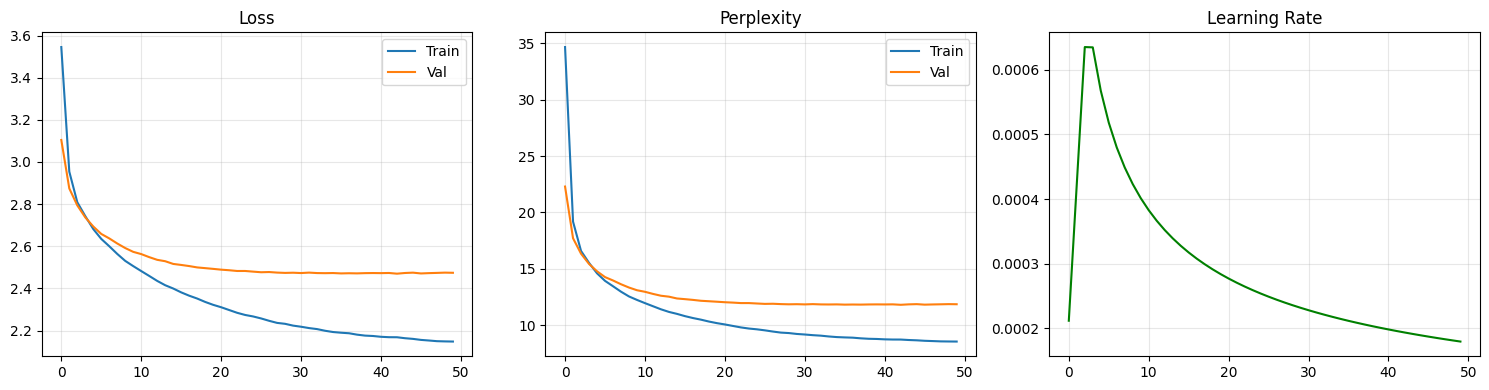

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(train_losses, label='Train'); ax[0].plot(val_losses, label='Val')
ax[0].set_title('Loss'); ax[0].legend(); ax[0].grid(True, alpha=0.3)
ax[1].plot([np.exp(l) for l in train_losses], label='Train'); ax[1].plot([np.exp(l) for l in val_losses], label='Val')
ax[1].set_title('Perplexity'); ax[1].legend(); ax[1].grid(True, alpha=0.3)
ax[2].plot(lrs, color='green'); ax[2].set_title('Learning Rate'); ax[2].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 13. 번역 테스트

In [17]:
ckpt = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=False)
model.load_state_dict(ckpt['model'])
model.eval()

tests = ['북한이 미사일을 발사했다.', '대통령이 기자회견을 열었다.', '주식 시장이 하락했다.']
for i, s in enumerate(tests, 1):
    print(f'\n[{i}] {s}')
    g, _ = translate(s, model, vocab_src, vocab_trg, device)
    print(f"    Greedy: {''.join(g).replace(' ', ' ').replace('</s>', '').strip()}")
    b = translate_beam(s, model, vocab_src, vocab_trg, device, beam=5)
    print(f"    Beam:   {''.join(b).replace(' ', ' ').replace('</s>', '').strip()}")


[1] 북한이 미사일을 발사했다.
    Greedy: 0▁iraq▁system▁when▁put▁area▁report▁senz▁move▁years▁spaceakiionlo▁couldiion▁through▁held▁through▁yesterday▁londonin▁with▁support▁awhethers▁some▁he▁billion▁morningcks▁move▁campaign▁since0▁for0▁go▁before0▁through0▁through▁through0▁go▁through0▁without▁london▁london▁londonal▁you
    Beam:   0y▁iraq▁sen▁iran▁system▁system▁system▁system▁on▁through▁senzz▁shouldi▁space▁through0▁through0▁go▁through0▁go▁through0▁go▁through0▁go▁before0▁through0▁go▁before0▁through0▁through0▁go▁before0▁through0▁through0▁through0▁go▁through0▁through0▁through0▁through0

[2] 대통령이 기자회견을 열었다.
    Greedy: 0▁youriol▁should▁opposition▁life▁capital0▁through▁go<unk>sin▁shouldi<unk>▁morning▁londonin▁should▁yesterday▁london▁since0▁your▁report▁irana▁year▁london▁friday▁londonsiion▁he▁billion▁law▁w▁move0▁for0▁through0▁through▁yesterday▁londonin▁set▁report▁londonin▁2▁morning▁london▁londonin▁morning
    Beam:   0▁yourioliol▁should▁opposition▁life▁capital0▁through0s▁through0s▁your▁report▁londons▁is▁bil

In [18]:
print('\n📋 테스트셋 샘플')
for i in range(5):
    src, trg = test_ds.src[i], test_ds.trg[i]
    b = translate_beam(src, model, vocab_src, vocab_trg, device, beam=5)
    pred = ''.join(b).replace('▁', ' ').replace('</s>', '').strip()
    print(f'\n[{i+1}] 원문: {src[:50]}...')
    print(f'    정답: {trg[:50]}...')
    print(f'    예측: {pred[:50]}...')


📋 테스트셋 샘플

[1] 원문: 이는 낙태 관련 국제 구호기구에 대한 이른바 ‘전방위재갈정책(gag order)’과 연방부...
    정답: one dealing with a so-called "gag" order on intern...
    예측: 0 for0 report this report’ youriiiiiiiii around0 f...

[2] 원문: 아타 장군의 참모는 “알가즐 시장에서 발생한 테러 용의자는 소위 ‘미친 여자’로 불리던 여...
    정답: an atta aide said that people referred to the bomb...
    예측: told told told told told told iran be toi this rep...

[3] 원문: 산토스의 첫 골 이후 바르셀로나는 한수 앞선 기량을 보이며 내내 경기를 주도했다....
    정답: andres iniesta made it 2-0 just before the hour ma...
    예측: 0 opposition press say0 opposition when0 oppositio...

[4] 원문: 크리스토파로 목사는 또 “이스라엘의 가호가 있기를 비는 자들은 축복을 받을 것”이라며 “반...
    정답: "there is a promise to those who bless israel to b...
    예측: 0 for0 for0 for0 for0 for0 for0 for0 for0 for0 for...

[5] 원문: 지난 주 부통령 비서실장직에서 사임하기 전까지 미국에서 가장 영향력 있는 핵심인사 중 한명...
    정답: he was one of the most powerful men in the us unti...
    예측: yesterday iraqi when yesterday iraq when yesterday...
